# analyze NCI cervical cnv and loh results

example loh file: 
/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-03-06-02242/hg19a/GSH/A57097_A56625/loh/tc_50/25662/results/apolloh_out_segs_annotated.txt

it looks like in the annotation file, loh state column
0= NLOH, ALOH, DLOH
1=HET,ASCNA
2=BCNA


Zygosity states are:
DLOH=deletion-LOH (state 1)
NLOH=copy-neutral-LOH (states 2,4)
ALOH=amplified-LOH (states 5,8,9,13,14,19)
HET=heterozygous (states 3,6,7)
ASCNA=allele-specific-amplification (states 10,12,15,18)
BCNA=balanced-amplification (states 11,16,17)
so my objective is to pull out all those genes in the annotation file with a loh state = 0

In [1]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from matplotlib import style
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn


In [2]:
df_loh = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/loh/loh_file_path.txt', header=None)
loh_files = df_loh[0].tolist()
for f in loh_files:
    patient = f.split('/')[4]
    # loh_files, some rows have 10 columns instead of 9, problems from the APLLOH pipeline
    loh = pd.read_csv(f, sep='\t',  error_bad_lines=False, warn_bad_lines=False)
    # select for DLOH, ALOH, NLOH
    loh = loh[loh['LOH_State'] == 0]
    loh['patient'] = patient
    loh = loh.drop_duplicates()
    if f == loh_files[0]:
        df_init = loh
    else:
        df_init = pd.concat([df_init, loh], axis=0)
df_init.to_csv('concat_loh_annotated.txt', sep='\t', index=False)

In [3]:
df = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/loh/concat_loh_annotated.txt', sep='\t')

# get oncogenes and tumor suppressor genes
df_genes = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/loh/recurrent_loh.txt', sep='\t', header=None)
genes = df_genes[0].tolist()
# genes

# get patients list
df_patients = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/82_patients/HIV_Cervical_patient.txt.hiv.sorted', header=None)
all_patients = df_patients[0].tolist()

In [4]:
with open('/projects/trans_scratch/validations/workspace/szong/Cervical/loh/loh_stats.txt',  'w') as fh:
    writer = csv.writer(fh, delimiter='\t')
    header = ['gene', 'occurrence'] + all_patients
    writer.writerow(header)
    for gene, group in df.groupby('Gene_Name'):
        if gene in genes:
            patients = group['patient'].unique()
            occurrence = len(patients)
            loh_stats = ['1' if i in patients else '0' for i in all_patients]
            content = [gene, occurrence] + loh_stats
            writer.writerow(content)


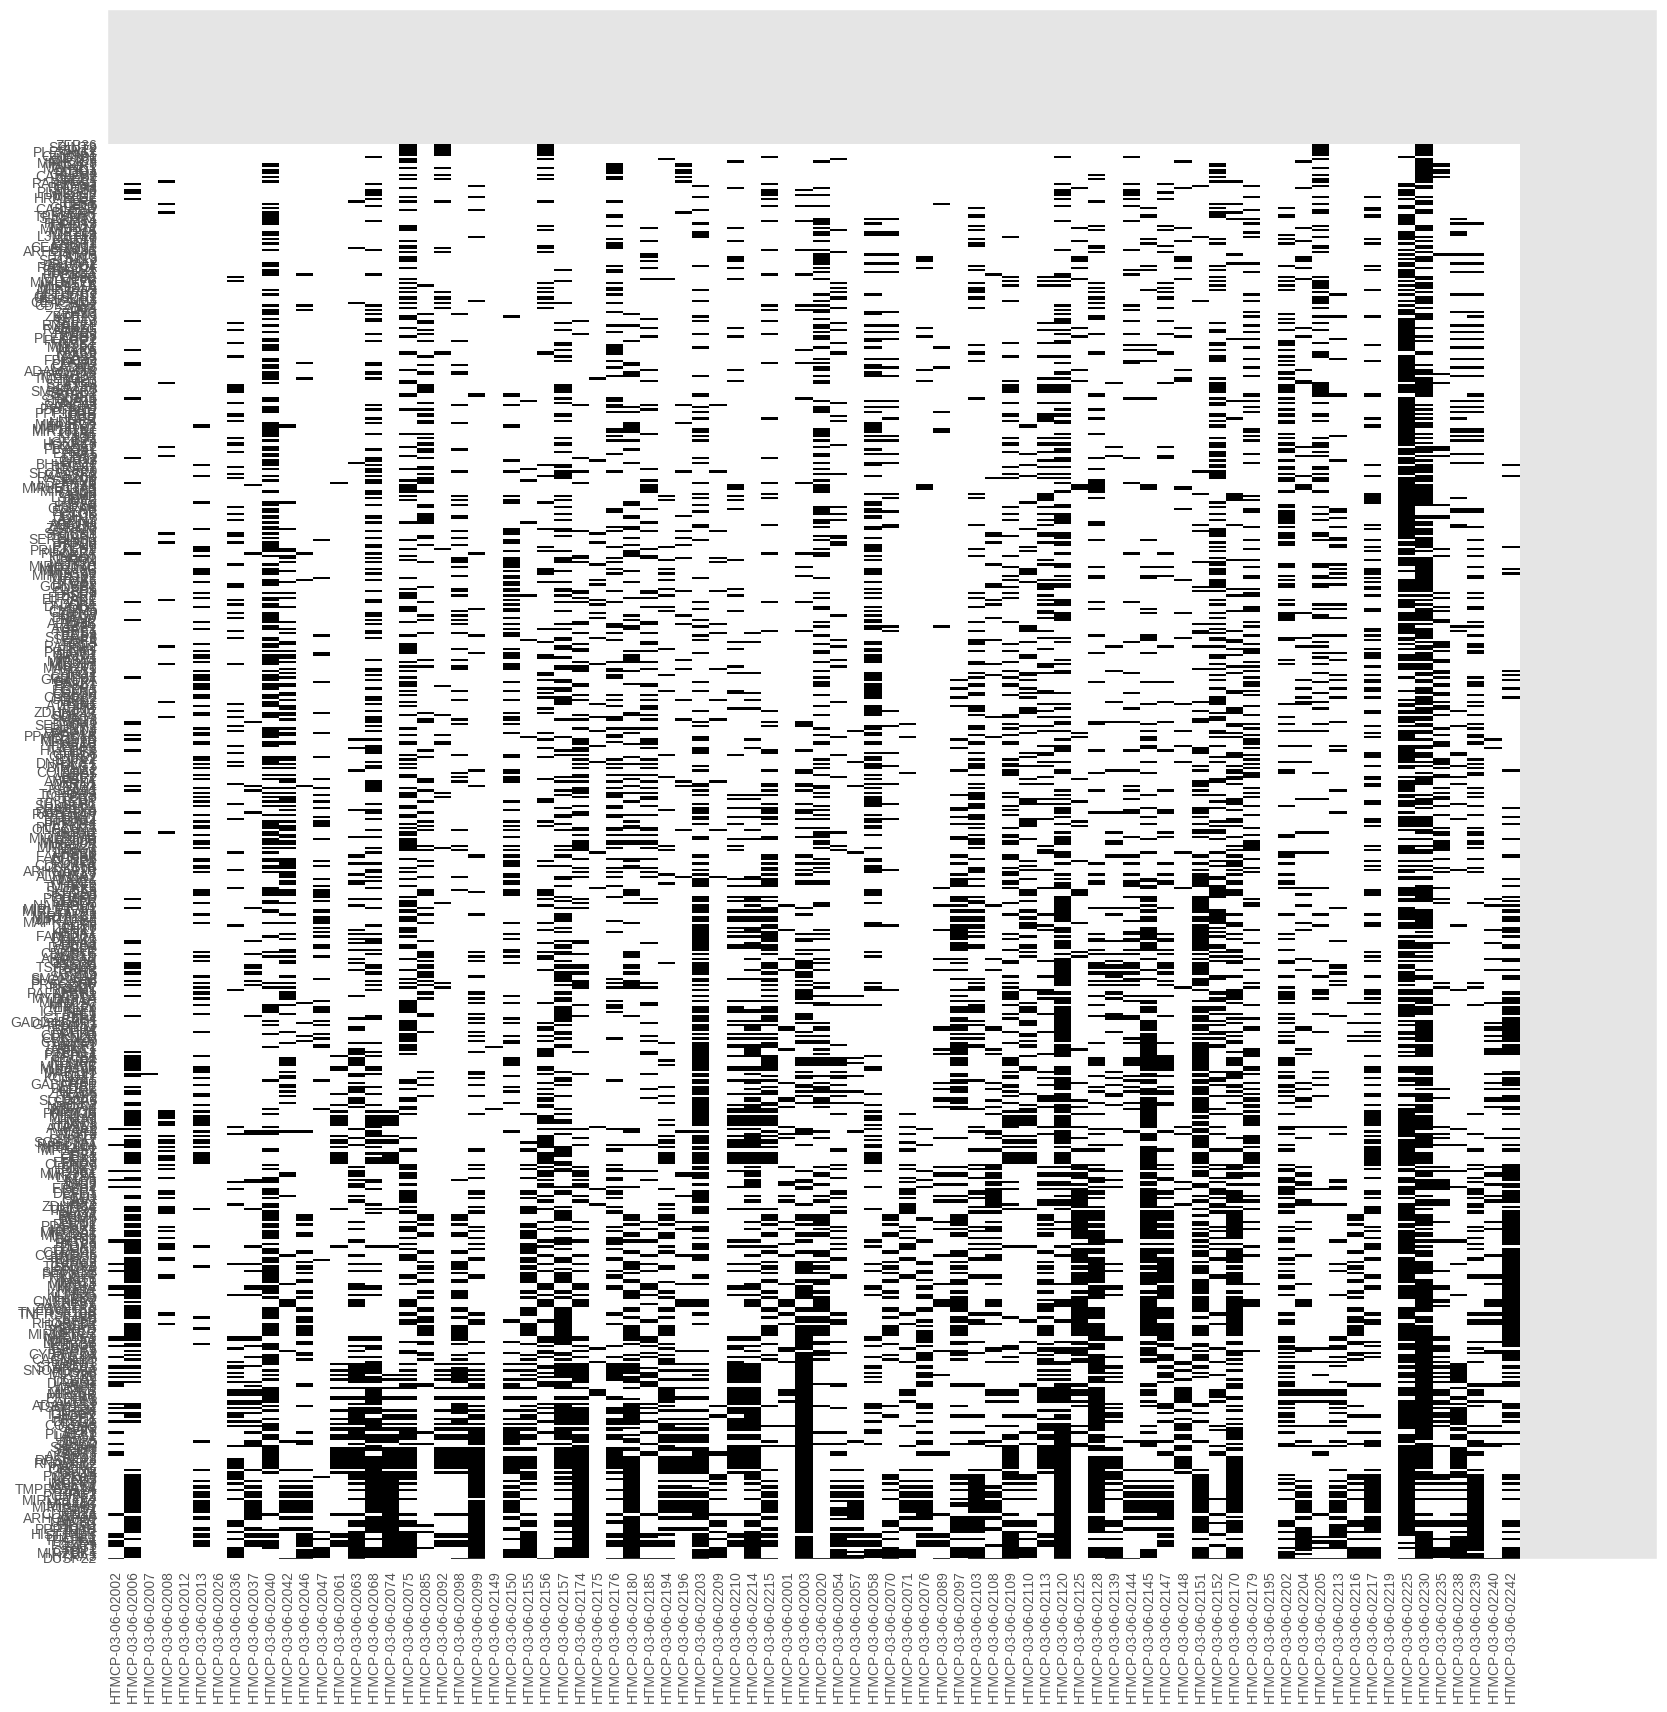

In [7]:
# manual sort loh_stats.txt based on occurrence
df =pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/loh/loh_stats.txt', sep='\t', index_col='gene')
df.drop('occurrence', axis=1, inplace=True)

matplotlib.rcParams['figure.figsize'] = (20, 20)
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
# plt.show()
plt.savefig('loh_status.png', dpi=200)

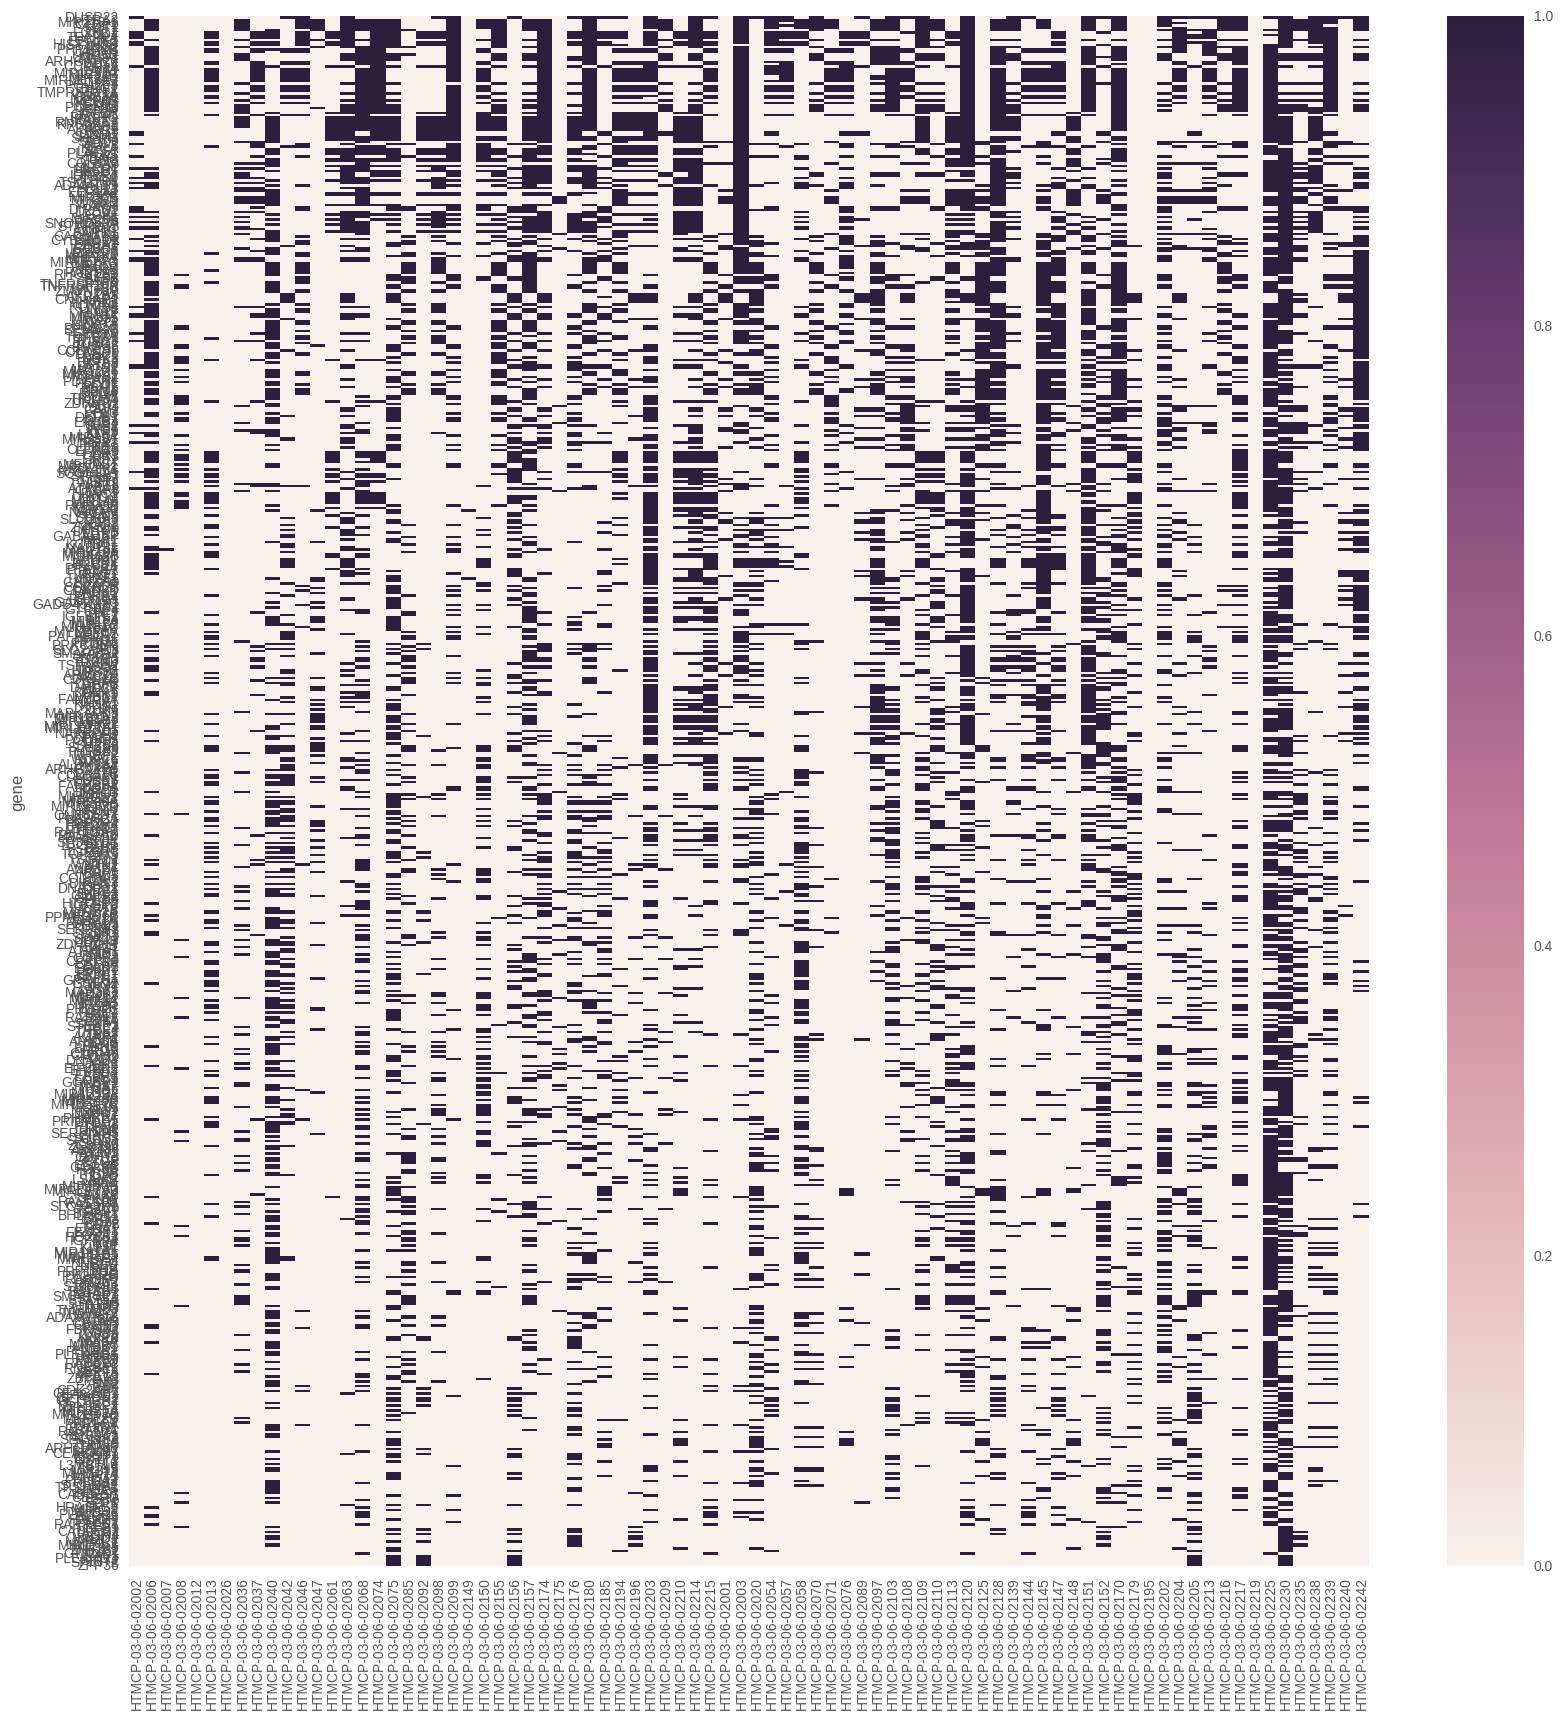

In [95]:
matplotlib.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(df)
plt.savefig('loh_status.png', dpi=200)